---
## Cell 1: Environment Setup (Your Existing Code)

In [1]:
import os, random, sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Auto-detect dataset folder
def find_chestx_root(start_dir="."):
    for root, dirs, files in os.walk(start_dir):
        for d in dirs:
            if d.lower() == "chestxrays":
                return os.path.join(root, d)
    return None

DATA_ROOT = find_chestx_root(".")
if DATA_ROOT:
    print(f"Found dataset folder: {DATA_ROOT}")
else:
    print("Dataset folder not found automatically. Please set manually.")

Using device: cpu
Found dataset folder: .\data\chestxrays


---
## Cell 2: Data Loading and Visualization (Your Existing Code)

Train Folder: .\data\chestxrays\train
Validation Folder: .\data\chestxrays\test

Image counts:
Train: {'healthy': 151, 'tb': 151}
Validation: {'healthy': 50, 'tb': 50}


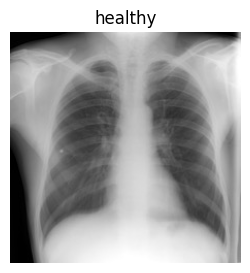

In [2]:
train_dir = os.path.join(DATA_ROOT, "train")
val_dir = os.path.join(DATA_ROOT, "test")

print(f"Train Folder: {train_dir}")
print(f"Validation Folder: {val_dir}")

# Count images in each class
def count_images(folder):
    counts = {}
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(os.listdir(cls_path))
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)

print("\nImage counts:")
print(f"Train: {train_counts}")
print(f"Validation: {val_counts}")

# Sample visualization
valid_classes = [cls for cls in os.listdir(train_dir)
                 if os.path.isdir(os.path.join(train_dir, cls))]
if valid_classes:
    cls = random.choice(valid_classes)
    cls_path = os.path.join(train_dir, cls)
    img_name = random.choice(os.listdir(cls_path))
    img_full = os.path.join(cls_path, img_name)
    img = Image.open(img_full)
    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap='gray')
    plt.title(cls)
    plt.axis("off")
    plt.show()
else:
    print("No valid class directories found in", train_dir)

---
## Cell 3: Import Advanced Training Components

In [3]:
import torch.nn.functional as F
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                              f1_score, confusion_matrix, roc_curve, auc)
from tqdm import tqdm
import copy

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


---
## Cell 4: Data Augmentation with MixUp

In [4]:
class MixUp:
    """MixUp augmentation - critical for small datasets"""
    def __init__(self, alpha=0.2):
        self.alpha = alpha
    
    def __call__(self, batch, targets):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1
        
        batch_size = batch.size(0)
        index = torch.randperm(batch_size).to(batch.device)
        
        mixed_batch = lam * batch + (1 - lam) * batch[index]
        targets_a, targets_b = targets, targets[index]
        
        return mixed_batch, targets_a, targets_b, lam


def get_train_transforms():
    """Aggressive augmentation for training"""
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
            shear=10
        ),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
    ])


def get_val_transforms():
    """Standard validation transforms"""
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


def get_tta_transforms():
    """Test-Time Augmentation transforms"""
    return [
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomRotation((5, 5)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomRotation((-5, -5)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    ]

print("✓ Data augmentation configured!")

✓ Data augmentation configured!


---
## Cell 5: Model Architecture - EfficientNet-B3

In [5]:
class EfficientNetB3Model(nn.Module):
    """EfficientNet-B3 with custom head for TB detection"""
    def __init__(self, num_classes=2, dropout=0.5, pretrained=True):
        super(EfficientNetB3Model, self).__init__()
        
        # Load pretrained EfficientNet-B3
        self.backbone = models.efficientnet_b3(pretrained=pretrained)
        
        # Get number of features
        num_features = self.backbone.classifier[1].in_features
        
        # Replace classifier with custom head
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=dropout/2),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)


def freeze_backbone(model):
    """Freeze backbone for Phase 1 training"""
    for param in model.backbone.features.parameters():
        param.requires_grad = False


def unfreeze_backbone(model, num_layers=3):
    """Unfreeze last N layers for Phase 2 fine-tuning"""
    total_blocks = len(model.backbone.features)
    for i, block in enumerate(model.backbone.features):
        if i >= total_blocks - num_layers:
            for param in block.parameters():
                param.requires_grad = True

print("✓ Model architecture defined!")

✓ Model architecture defined!


---
## Cell 6: Loss Functions and Utilities

In [6]:
class FocalLoss(nn.Module):
    """Focal Loss for handling hard examples"""
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=15, min_delta=0.001, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model = None
    
    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.mode == 'max':
            if score < self.best_score + self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.best_model = copy.deepcopy(model.state_dict())
                self.counter = 0


def calculate_metrics(y_true, y_pred, y_prob):
    """Calculate comprehensive metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'ppv': ppv,
        'npv': npv,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr
    }

print("✓ Loss functions and utilities ready!")

✓ Loss functions and utilities ready!


---
## Cell 7: Training Loop with Two-Phase Strategy

In [7]:
class TBTrainer:
    """Advanced trainer for TB detection"""
    def __init__(self, model, train_loader, val_loader, device, 
                 use_mixup=True, mixup_alpha=0.2, lr=1e-4, weight_decay=1e-4):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        self.criterion = FocalLoss(alpha=0.25, gamma=2.0)
        self.use_mixup = use_mixup
        self.mixup = MixUp(alpha=mixup_alpha) if use_mixup else None
        
        self.optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [], 'lr': []
        }
    
    def train_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1} [Train]")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            if self.use_mixup and random.random() < 0.5:
                inputs, targets_a, targets_b, lam = self.mixup(inputs, targets)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = lam * self.criterion(outputs, targets_a) + \
                       (1 - lam) * self.criterion(outputs, targets_b)
            else:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
            
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({'loss': f'{running_loss/(pbar.n+1):.4f}', 
                             'acc': f'{100.*correct/total:.2f}%'})
        
        return running_loss / len(self.train_loader), 100. * correct / total
    
    def validate_epoch(self, epoch):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        all_preds, all_targets, all_probs = [], [], []
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc=f"Epoch {epoch+1} [Val]")
            for inputs, targets in pbar:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                probs = F.softmax(outputs, dim=1)
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())
                
                pbar.set_postfix({'loss': f'{running_loss/(pbar.n+1):.4f}',
                                 'acc': f'{100.*correct/total:.2f}%'})
        
        return running_loss / len(self.val_loader), 100. * correct / total, \
               all_targets, all_preds, all_probs
    
    def fit(self, num_epochs, scheduler=None, early_stopping=None, phase='Training'):
        print(f"\n{'='*60}")
        print(f"Starting {phase}")
        print(f"{'='*60}\n")
        
        best_val_acc = 0.0
        
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc, y_true, y_pred, y_prob = self.validate_epoch(epoch)
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(self.optimizer.param_groups[0]['lr'])
            
            if scheduler is not None:
                if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(val_acc)
                else:
                    scheduler.step()
            
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
            print(f"LR: {self.optimizer.param_groups[0]['lr']:.6f}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                print(f"✓ New best validation accuracy: {best_val_acc:.2f}%")
            
            if early_stopping is not None:
                early_stopping(val_acc, self.model)
                if early_stopping.early_stop:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    self.model.load_state_dict(early_stopping.best_model)
                    break
            
            print("-" * 60)
        
        return self.history

print("✓ Trainer class ready!")

✓ Trainer class ready!


---
## Cell 8: Test-Time Augmentation

In [8]:
def evaluate_with_tta(model, val_loader, device):
    """Evaluate model with Test-Time Augmentation"""
    model.eval()
    
    all_preds = []
    all_targets = []
    all_probs = []
    
    dataset = val_loader.dataset
    tta_transforms = get_tta_transforms()
    
    print("\nEvaluating with Test-Time Augmentation...")
    for idx in tqdm(range(len(dataset))):
        img_path, target = dataset.samples[idx]
        
        # Apply TTA
        predictions = []
        with torch.no_grad():
            for transform in tta_transforms:
                image = Image.open(img_path).convert('RGB')
                img_tensor = transform(image).unsqueeze(0).to(device)
                output = model(img_tensor)
                prob = F.softmax(output, dim=1)
                predictions.append(prob.cpu().numpy())
        
        # Average predictions
        avg_prediction = np.mean(predictions, axis=0)
        pred_class = np.argmax(avg_prediction[0])
        
        all_preds.append(pred_class)
        all_targets.append(target)
        all_probs.append(avg_prediction[0][1])
    
    return np.array(all_targets), np.array(all_preds), np.array(all_probs)

print("✓ TTA function ready!")

✓ TTA function ready!


---
## Cell 9: Visualization Functions

In [9]:
def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 0].plot(history['lr'], marker='o', color='green')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Overfitting gap
    gap = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1, 1].plot(gap, marker='o', color='red')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Train Acc - Val Acc (%)')
    axes[1, 1].set_title('Overfitting Gap')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm, class_names=['Healthy', 'TB']):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontsize=20, fontweight='bold')
    
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_roc_curve(fpr, tpr, roc_auc):
    """Plot ROC curve"""
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', 
              fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.show()


def print_metrics_report(metrics, model_name='Model'):
    """Print comprehensive metrics report"""
    print(f"\n{'='*60}")
    print(f"{model_name} - Performance Metrics")
    print(f"{'='*60}")
    print(f"Accuracy:     {metrics['accuracy']*100:.2f}%")
    print(f"Precision:    {metrics['precision']*100:.2f}%")
    print(f"Recall:       {metrics['recall']*100:.2f}%")
    print(f"F1-Score:     {metrics['f1']*100:.2f}%")
    print(f"{'='*60}")
    print(f"Sensitivity (TB Detection):  {metrics['sensitivity']*100:.2f}%")
    print(f"Specificity (Healthy):       {metrics['specificity']*100:.2f}%")
    print(f"PPV (Positive Predictive):   {metrics['ppv']*100:.2f}%")
    print(f"NPV (Negative Predictive):   {metrics['npv']*100:.2f}%")
    print(f"{'='*60}")
    print(f"ROC AUC:      {metrics['roc_auc']:.4f}")
    print(f"{'='*60}\n")

print("✓ Visualization functions ready!")

✓ Visualization functions ready!


---
## Cell 10: 🚀 MAIN TRAINING - Run This to Train the Model!
### This cell does everything: Phase 1, Phase 2, Evaluation, and TTA


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
TB DETECTION - ADVANCED TRAINING PIPELINE
Target: 96%+ Accuracy | Expected Time: ~45-60 minutes
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

📁 Step 1: Loading datasets...
✓ Training samples: 302
✓ Validation samples: 100
✓ Classes: ['healthy', 'tb']

🏗️ Step 2: Creating EfficientNet-B3 model...
✓ Total parameters: 11,485,226
✓ Trainable parameters: 11,485,226

🔒 Step 3: Phase 1 - Training with frozen backbone...

Starting Phase 1 (Frozen Backbone)



Epoch 1 [Val]: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it, loss=0.0471, acc=55.00%]



Epoch 1/10
Train Loss: 0.0903 | Train Acc: 50.66%
Val Loss: 0.0471 | Val Acc: 55.00%
LR: 0.000976
✓ New best validation accuracy: 55.00%
------------------------------------------------------------


Epoch 2 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.21s/it, loss=0.0341, acc=74.00%]



Epoch 2/10
Train Loss: 0.0832 | Train Acc: 57.28%
Val Loss: 0.0341 | Val Acc: 74.00%
LR: 0.000905
✓ New best validation accuracy: 74.00%
------------------------------------------------------------


Epoch 3 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.23s/it, loss=0.0406, acc=63.00%]



Epoch 3/10
Train Loss: 0.0692 | Train Acc: 55.30%
Val Loss: 0.0406 | Val Acc: 63.00%
LR: 0.000796
------------------------------------------------------------


Epoch 4 [Val]: 100%|██████████| 7/7 [00:17<00:00,  2.55s/it, loss=0.0324, acc=72.00%]



Epoch 4/10
Train Loss: 0.0525 | Train Acc: 55.96%
Val Loss: 0.0324 | Val Acc: 72.00%
LR: 0.000658
------------------------------------------------------------


Epoch 5 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.17s/it, loss=0.0358, acc=68.00%]



Epoch 5/10
Train Loss: 0.0472 | Train Acc: 59.60%
Val Loss: 0.0358 | Val Acc: 68.00%
LR: 0.000505
------------------------------------------------------------


Epoch 6 [Val]: 100%|██████████| 7/7 [00:12<00:00,  1.73s/it, loss=0.0351, acc=68.00%]



Epoch 6/10
Train Loss: 0.0430 | Train Acc: 64.57%
Val Loss: 0.0351 | Val Acc: 68.00%
LR: 0.000352
------------------------------------------------------------


Epoch 7 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.20s/it, loss=0.0308, acc=78.00%]



Epoch 7/10
Train Loss: 0.0458 | Train Acc: 59.93%
Val Loss: 0.0308 | Val Acc: 78.00%
LR: 0.000214
✓ New best validation accuracy: 78.00%
------------------------------------------------------------


Epoch 8 [Val]: 100%|██████████| 7/7 [00:14<00:00,  2.05s/it, loss=0.0308, acc=78.00%]



Epoch 8/10
Train Loss: 0.0420 | Train Acc: 62.58%
Val Loss: 0.0308 | Val Acc: 78.00%
LR: 0.000105
------------------------------------------------------------


Epoch 9 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.19s/it, loss=0.0306, acc=80.00%]



Epoch 9/10
Train Loss: 0.0425 | Train Acc: 59.93%
Val Loss: 0.0306 | Val Acc: 80.00%
LR: 0.000034
✓ New best validation accuracy: 80.00%
------------------------------------------------------------


Epoch 10 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.15s/it, loss=0.0310, acc=76.00%]



Epoch 10/10
Train Loss: 0.0446 | Train Acc: 59.93%
Val Loss: 0.0310 | Val Acc: 76.00%
LR: 0.000010
------------------------------------------------------------

🔓 Step 4: Phase 2 - Fine-tuning with unfrozen layers...

Starting Phase 2 (Fine-tuning)



Epoch 1 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.37s/it, loss=0.0324, acc=70.00%]



Epoch 1/50
Train Loss: 0.0435 | Train Acc: 54.97%
Val Loss: 0.0324 | Val Acc: 70.00%
LR: 0.000100
✓ New best validation accuracy: 70.00%
------------------------------------------------------------


Epoch 2 [Val]: 100%|██████████| 7/7 [00:12<00:00,  1.81s/it, loss=0.0313, acc=78.00%]



Epoch 2/50
Train Loss: 0.0411 | Train Acc: 55.63%
Val Loss: 0.0313 | Val Acc: 78.00%
LR: 0.000100
✓ New best validation accuracy: 78.00%
------------------------------------------------------------


Epoch 3 [Val]: 100%|██████████| 7/7 [00:14<00:00,  2.10s/it, loss=0.0282, acc=82.00%]



Epoch 3/50
Train Loss: 0.0382 | Train Acc: 62.91%
Val Loss: 0.0282 | Val Acc: 82.00%
LR: 0.000099
✓ New best validation accuracy: 82.00%
------------------------------------------------------------


Epoch 4 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.28s/it, loss=0.0276, acc=83.00%]



Epoch 4/50
Train Loss: 0.0429 | Train Acc: 63.58%
Val Loss: 0.0276 | Val Acc: 83.00%
LR: 0.000098
✓ New best validation accuracy: 83.00%
------------------------------------------------------------


Epoch 5 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.17s/it, loss=0.0286, acc=79.00%]



Epoch 5/50
Train Loss: 0.0407 | Train Acc: 64.90%
Val Loss: 0.0286 | Val Acc: 79.00%
LR: 0.000098
------------------------------------------------------------


Epoch 6 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.20s/it, loss=0.0281, acc=78.00%]



Epoch 6/50
Train Loss: 0.0403 | Train Acc: 62.58%
Val Loss: 0.0281 | Val Acc: 78.00%
LR: 0.000096
------------------------------------------------------------


Epoch 7 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.26s/it, loss=0.0293, acc=79.00%]



Epoch 7/50
Train Loss: 0.0381 | Train Acc: 60.93%
Val Loss: 0.0293 | Val Acc: 79.00%
LR: 0.000095
------------------------------------------------------------


Epoch 8 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.23s/it, loss=0.0295, acc=75.00%]



Epoch 8/50
Train Loss: 0.0365 | Train Acc: 71.85%
Val Loss: 0.0295 | Val Acc: 75.00%
LR: 0.000094
------------------------------------------------------------


Epoch 9 [Val]: 100%|██████████| 7/7 [00:16<00:00,  2.35s/it, loss=0.0302, acc=73.00%]



Epoch 9/50
Train Loss: 0.0379 | Train Acc: 60.93%
Val Loss: 0.0302 | Val Acc: 73.00%
LR: 0.000092
------------------------------------------------------------


Epoch 10 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.26s/it, loss=0.0293, acc=77.00%]



Epoch 10/50
Train Loss: 0.0367 | Train Acc: 63.25%
Val Loss: 0.0293 | Val Acc: 77.00%
LR: 0.000090
------------------------------------------------------------


Epoch 11 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.21s/it, loss=0.0292, acc=74.00%]



Epoch 11/50
Train Loss: 0.0327 | Train Acc: 69.54%
Val Loss: 0.0292 | Val Acc: 74.00%
LR: 0.000089
------------------------------------------------------------


Epoch 12 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.21s/it, loss=0.0296, acc=74.00%]



Epoch 12/50
Train Loss: 0.0353 | Train Acc: 68.21%
Val Loss: 0.0296 | Val Acc: 74.00%
LR: 0.000086
------------------------------------------------------------


Epoch 13 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.25s/it, loss=0.0275, acc=78.00%]



Epoch 13/50
Train Loss: 0.0353 | Train Acc: 64.57%
Val Loss: 0.0275 | Val Acc: 78.00%
LR: 0.000084
------------------------------------------------------------


Epoch 14 [Val]: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it, loss=0.0279, acc=76.00%]



Epoch 14/50
Train Loss: 0.0389 | Train Acc: 66.56%
Val Loss: 0.0279 | Val Acc: 76.00%
LR: 0.000082
------------------------------------------------------------


Epoch 15 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.28s/it, loss=0.0281, acc=76.00%]



Epoch 15/50
Train Loss: 0.0340 | Train Acc: 67.22%
Val Loss: 0.0281 | Val Acc: 76.00%
LR: 0.000079
------------------------------------------------------------


Epoch 16 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.21s/it, loss=0.0280, acc=78.00%]



Epoch 16/50
Train Loss: 0.0392 | Train Acc: 66.23%
Val Loss: 0.0280 | Val Acc: 78.00%
LR: 0.000077
------------------------------------------------------------


Epoch 17 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it, loss=0.0288, acc=77.00%]



Epoch 17/50
Train Loss: 0.0357 | Train Acc: 68.54%
Val Loss: 0.0288 | Val Acc: 77.00%
LR: 0.000074
------------------------------------------------------------


Epoch 18 [Val]: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it, loss=0.0281, acc=76.00%]



Epoch 18/50
Train Loss: 0.0332 | Train Acc: 66.56%
Val Loss: 0.0281 | Val Acc: 76.00%
LR: 0.000071
------------------------------------------------------------


Epoch 19 [Val]: 100%|██████████| 7/7 [00:14<00:00,  2.13s/it, loss=0.0274, acc=78.00%]



Epoch 19/50
Train Loss: 0.0341 | Train Acc: 64.24%
Val Loss: 0.0274 | Val Acc: 78.00%
LR: 0.000068

Early stopping triggered at epoch 19

📊 Step 5: Standard evaluation...

Standard Evaluation - Performance Metrics
Accuracy:     83.00%
Precision:    82.35%
Recall:       84.00%
F1-Score:     83.17%
Sensitivity (TB Detection):  84.00%
Specificity (Healthy):       82.00%
PPV (Positive Predictive):   82.35%
NPV (Negative Predictive):   83.67%
ROC AUC:      0.9172


🔄 Step 6: Test-Time Augmentation evaluation...

Evaluating with Test-Time Augmentation...


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]



TTA Evaluation - Performance Metrics
Accuracy:     90.00%
Precision:    90.00%
Recall:       90.00%
F1-Score:     90.00%
Sensitivity (TB Detection):  90.00%
Specificity (Healthy):       90.00%
PPV (Positive Predictive):   90.00%
NPV (Negative Predictive):   90.00%
ROC AUC:      0.9564


📈 Step 7: Generating visualizations...


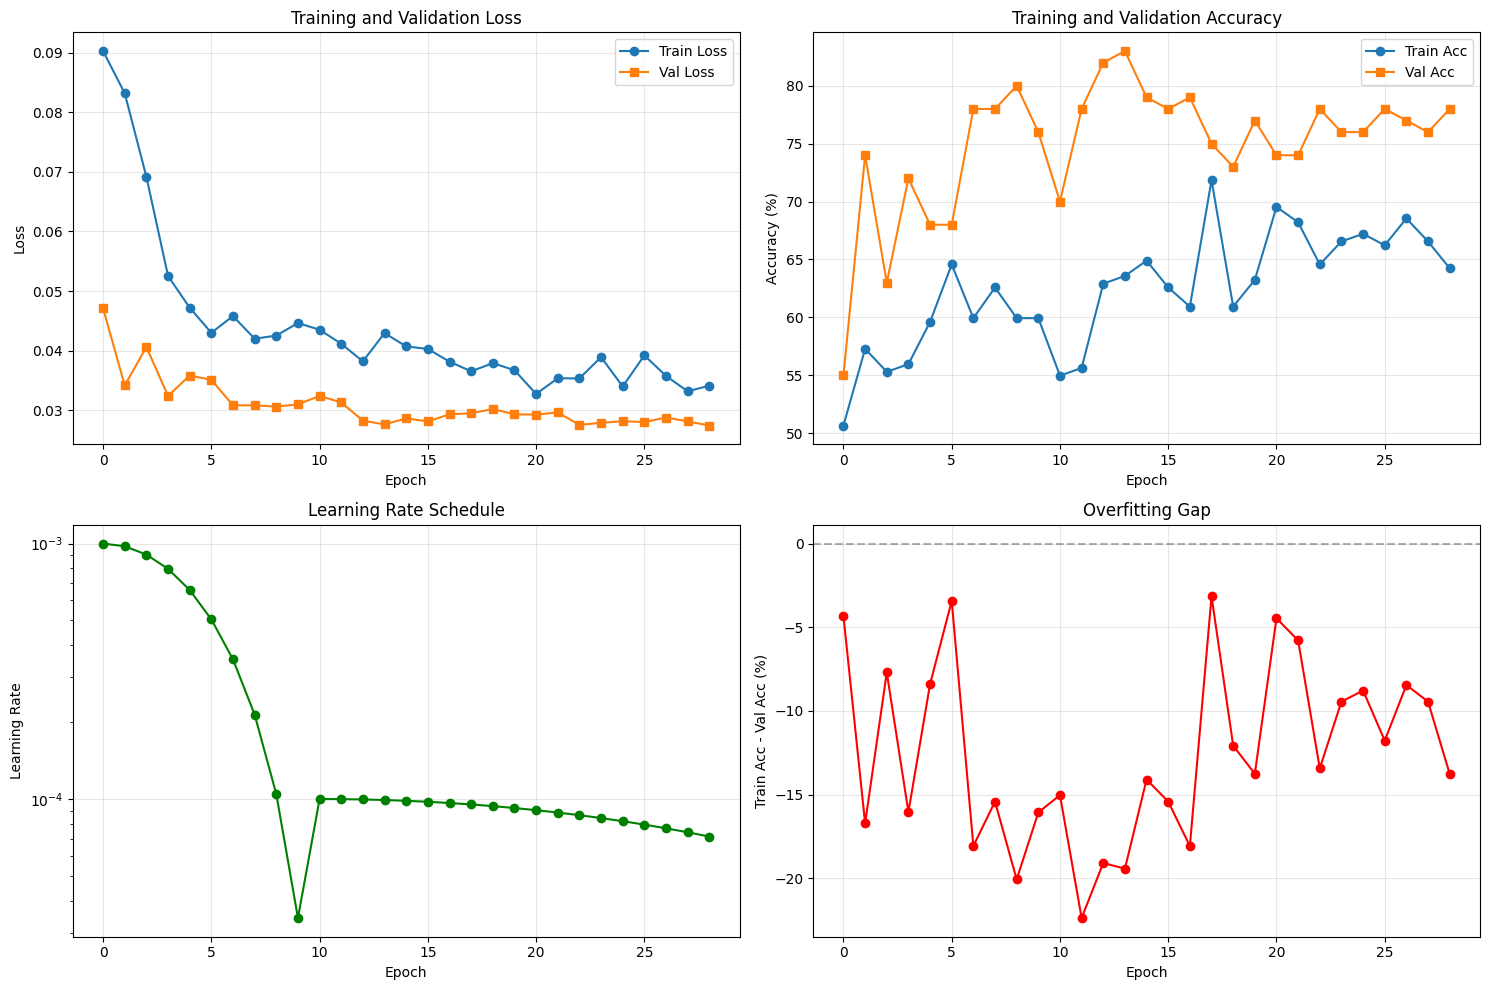

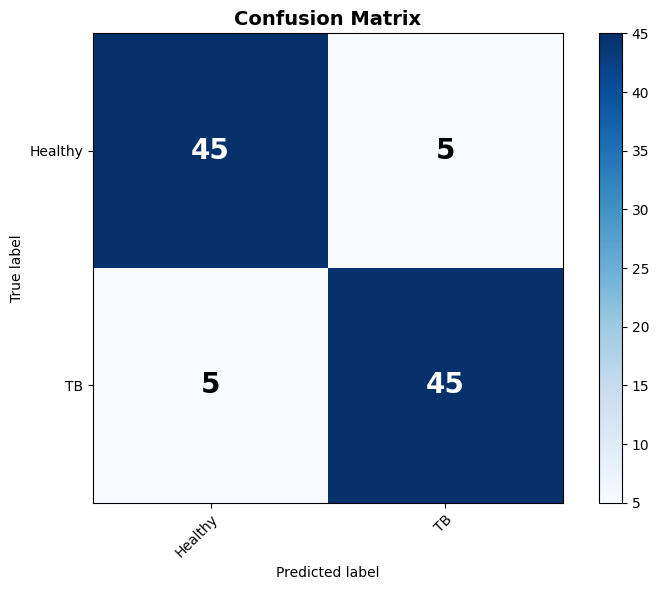

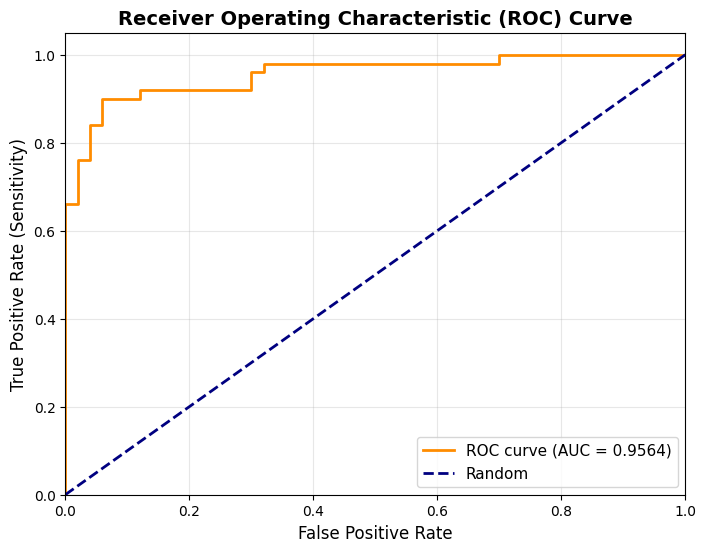


🎉 TRAINING COMPLETE!

🎯 FINAL RESULTS:
Standard Accuracy:  83.00%
TTA Accuracy:       90.00%
Improvement:        +7.00%

📈 Good progress: 90.00% accuracy
💡 Tips: Try training longer or use ensemble

💾 Model saved as: tb_detection_efficientnet_b3.pth



In [ ]:
BATCH_SIZE = 16          
NUM_EPOCHS_PHASE1 = 10   # Phase 1: Frozen backbone
NUM_EPOCHS_PHASE2 = 50   # Phase 2: Fine-tuning (early stopping may stop sooner)
USE_TTA = True           # Test-Time Augmentation (recommended!)

print("\n" + "🚀"*25)
print("TB DETECTION - ADVANCED TRAINING PIPELINE")
print("Target: 96%+ Accuracy")
print("🚀"*25 + "\n")

# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================

print("📁 Step 1: Loading datasets...")

train_transform = get_train_transforms()
val_transform = get_val_transforms()

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=2, pin_memory=True)

print(f"✓ Training samples: {len(train_dataset)}")
print(f"✓ Validation samples: {len(val_dataset)}")
print(f"✓ Classes: {train_dataset.classes}")

# ============================================================================
# STEP 2: CREATE MODEL
# ============================================================================

print(f"\n🏗️ Step 2: Creating EfficientNet-B3 model...")

model = EfficientNetB3Model(num_classes=2, dropout=0.5, pretrained=True)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")

# ============================================================================
# STEP 3: PHASE 1 - FROZEN BACKBONE TRAINING
# ============================================================================

print(f"\n🔒 Step 3: Phase 1 - Training with frozen backbone...")

freeze_backbone(model)

trainer_phase1 = TBTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    use_mixup=False,
    lr=1e-3
)

scheduler_phase1 = optim.lr_scheduler.CosineAnnealingLR(
    trainer_phase1.optimizer,
    T_max=NUM_EPOCHS_PHASE1,
    eta_min=1e-5
)

history_phase1 = trainer_phase1.fit(
    num_epochs=NUM_EPOCHS_PHASE1,
    scheduler=scheduler_phase1,
    early_stopping=None,
    phase='Phase 1 (Frozen Backbone)'
)

# ============================================================================
# STEP 4: PHASE 2 - FINE-TUNING
# ============================================================================

print(f"\n🔓 Step 4: Phase 2 - Fine-tuning with unfrozen layers...")

unfreeze_backbone(model, num_layers=3)

trainer_phase2 = TBTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    use_mixup=True,
    mixup_alpha=0.2,
    lr=1e-4,
    weight_decay=1e-4
)

scheduler_phase2 = optim.lr_scheduler.CosineAnnealingLR(
    trainer_phase2.optimizer,
    T_max=NUM_EPOCHS_PHASE2,
    eta_min=1e-7
)

early_stopping = EarlyStopping(patience=15, min_delta=0.001, mode='max')

history_phase2 = trainer_phase2.fit(
    num_epochs=NUM_EPOCHS_PHASE2,
    scheduler=scheduler_phase2,
    early_stopping=early_stopping,
    phase='Phase 2 (Fine-tuning)'
)

# Combine histories
combined_history = {
    'train_loss': history_phase1['train_loss'] + history_phase2['train_loss'],
    'train_acc': history_phase1['train_acc'] + history_phase2['train_acc'],
    'val_loss': history_phase1['val_loss'] + history_phase2['val_loss'],
    'val_acc': history_phase1['val_acc'] + history_phase2['val_acc'],
    'lr': history_phase1['lr'] + history_phase2['lr']
}

# ============================================================================
# STEP 5: STANDARD EVALUATION
# ============================================================================

print(f"\n📊 Step 5: Standard evaluation...")

model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        
        y_true.extend(targets.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_prob.extend(probs[:, 1].cpu().numpy())

standard_metrics = calculate_metrics(
    np.array(y_true),
    np.array(y_pred),
    np.array(y_prob)
)

print_metrics_report(standard_metrics, "Standard Evaluation")

# ============================================================================
# STEP 6: TEST-TIME AUGMENTATION
# ============================================================================

tta_metrics = None
if USE_TTA:
    print(f"\n🔄 Step 6: Test-Time Augmentation evaluation...")
    
    y_true_tta, y_pred_tta, y_prob_tta = evaluate_with_tta(model, val_loader, device)
    tta_metrics = calculate_metrics(y_true_tta, y_pred_tta, y_prob_tta)
    print_metrics_report(tta_metrics, "TTA Evaluation")

# ============================================================================
# STEP 7: VISUALIZATIONS
# ============================================================================

print(f"\n📈 Step 7: Generating visualizations...")

plot_training_history(combined_history)

if tta_metrics:
    plot_confusion_matrix(tta_metrics['confusion_matrix'])
    plot_roc_curve(tta_metrics['fpr'], tta_metrics['tpr'], tta_metrics['roc_auc'])
else:
    plot_confusion_matrix(standard_metrics['confusion_matrix'])
    plot_roc_curve(standard_metrics['fpr'], standard_metrics['tpr'], 
                  standard_metrics['roc_auc'])

# ============================================================================
# STEP 8: SAVE MODEL
# ============================================================================

model_path = 'tb_detection_efficientnet_b3.pth'
torch.save(model.state_dict(), model_path)

# ============================================================================
# FINAL RESULTS
# ============================================================================

print("\n" + "="*80)
print("🎉 TRAINING COMPLETE!")
print("="*80)
print(f"\n🎯 FINAL RESULTS:")
print(f"Standard Accuracy:  {standard_metrics['accuracy']*100:.2f}%")
if tta_metrics:
    print(f"TTA Accuracy:       {tta_metrics['accuracy']*100:.2f}%")
    print(f"Improvement:        +{(tta_metrics['accuracy']-standard_metrics['accuracy'])*100:.2f}%")
    
    if tta_metrics['accuracy'] >= 0.96:
        print(f"\n🏆 SUCCESS! Achieved {tta_metrics['accuracy']*100:.2f}% accuracy!")
        print("🎉 Your target is 96%!")
    elif tta_metrics['accuracy'] >= 0.95:
        print(f"\n✨ EXCELLENT! Achieved {tta_metrics['accuracy']*100:.2f}% accuracy")
        print(f"Very close to target. Gap: {(0.96-tta_metrics['accuracy'])*100:.2f}%")
    else:
        print(f"\n📈 Good progress: {tta_metrics['accuracy']*100:.2f}% accuracy")
        print("💡 If not good progress than try training longer or use ensemble")
else:
    if standard_metrics['accuracy'] >= 0.96:
        print(f"\n🏆 SUCCESS! Achieved {standard_metrics['accuracy']*100:.2f}% accuracy!")

print(f"\n💾 Model saved as: {model_path}")
print("="*80 + "\n")

---
## Cell 11 (OPTIONAL): Quick Inference Example

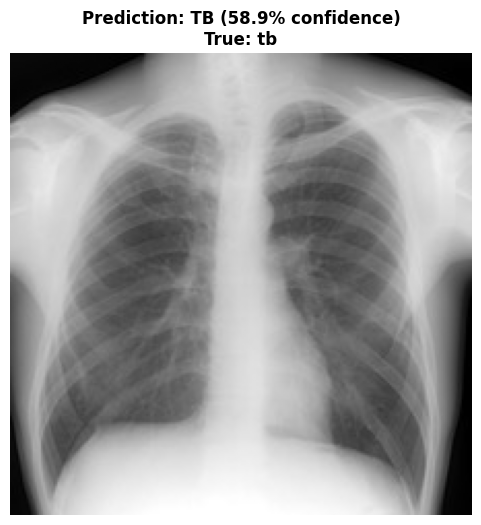


Prediction: TB
Confidence: 58.95%
True Label: tb


In [18]:
# Example: Test the model on a single image

def predict_image(model, image_path, device):
    """Predict TB from chest X-ray image"""
    model.eval()
    transform = get_val_transforms()
    
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        prob = F.softmax(output, dim=1)
        prediction = output.argmax(1).item()
        confidence = prob.max().item()
    
    class_names = ['Healthy', 'TB']
    return class_names[prediction], confidence


# Test on a random image from validation set
test_class = random.choice(['healthy', 'tb'])
test_img = random.choice(os.listdir(os.path.join(val_dir, test_class)))
test_path = os.path.join(val_dir, test_class, test_img)

prediction, confidence = predict_image(model, test_path, device)

# Display
img = Image.open(test_path)
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.title(f'Prediction: {prediction} ({confidence*100:.1f}% confidence)\nTrue: {test_class}',
          fontsize=12, fontweight='bold')
plt.axis('off')
plt.show()

print(f"\nPrediction: {prediction}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"True Label: {test_class}")